# Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from os.path import join
import datetime
import os

from CNN.models.base_line import BasicModel
from CNN.training.trainer_base import Trainer
from CNN.utils.transforms import ResizeTransform
from CNN.modules.cross_validation import MyKFoldCV
from CNN.modules.dataset_handling import DatasetHandler
from CNN.modules.logging import MyLogger
from CNN.utils.metrics import compute_confusion_matrices, compute_accuracy, compute_f1score

torch.manual_seed(42)

# Params

In [8]:
in_size = 128             # the input images are resized to squares with length of in_size
out_size = 2              # only 2 classes are present in the current dataset
outer_kfolds = 5
inner_kfolds = 4
batch_size = 32
learning_rate = 0.01
labels = [1, 0]
condition = 'complex'     # unambiguous, simple or complex
model_type = 'base'       # base or other networks that might appear in future
num_epochs = 20            # number of epochs per one inner fold
verbose = True
autosave = False          # save intermediate models during training when better validation accuracy is reached 
save_model = False         # save the final model
project_path = 'C:/Users/timur/uds/Thesis-Project/'
data_path = 'analysis/data/gaze_plots/'  


# Prepare for Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if model_type == 'base':
    model = BasicModel(in_size, out_size)
if verbose:
    print('using device: ' + device.__str__())
# Create a dataset from image folder
root = join(project_path, data_path, condition)
assert os.path.exists(root), 'The folder with images does not exist'

transform = ResizeTransform(in_size, in_size)

if verbose:
    print(f'Creating dataset from this folder: {root}')

dataset = DatasetHandler(root, transform, sorted(labels))

outer_cv = MyKFoldCV(dataset, outer_kfolds, create_train_loaders=False, batch_size=batch_size)

# Define the loss function
loss = nn.CrossEntropyLoss()

# Define logger
logger = MyLogger(join(project_path, 'experiments/{}_{}_{}/'.format(condition, model_type, in_size)))

cur_time = str(datetime.datetime.now().strftime("%d.%m_%H%M"))

# Define trainer 
save_path = join(project_path, 'saved_models/{}s_{}_{}/'.format(condition, model_type, cur_time))

trainer = Trainer(model, save_path, loss, logger=logger, autosave=autosave)

using device: cuda
Creating dataset from this folder: C:/Users/timur/uds/Thesis-Project/analysis/data/gaze_plots/complex


# Training

In [10]:
for i in range(outer_cv.k):
    trainer.reset()
    logger.log_new_fold(i+1, outer_cv.get_test_participants())
    inner_cv = MyKFoldCV(dataset, inner_kfolds, ignore=outer_cv.get_test_participants(), batch_size=batch_size)
    if verbose:
        print(f'outer fold: {i+1}')
        print('testing on: ', outer_cv.get_test_participants())
    if model_type == 'base':
            model = BasicModel(in_size, out_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    trainer.set_optimizer(optimizer)
    trainer.set_model(model)
    trainer.set_save_path(join(save_path, f'fold_{i+1}'))
    # training
    for j in range(inner_cv.k):
        if verbose:
            print(f'inner fold: {j+1}')
            print('training on: ', inner_cv.get_participants())
        train_loader = inner_cv.get_train_loader()
        test_loader = inner_cv.get_test_loader()
        if verbose:
            print('validating on: ', inner_cv.get_test_participants())
        trainer.set_train_loader(train_loader)
        trainer.set_val_loader(test_loader)
        for _ in range(num_epochs):
            trainer.run_epoch()
        inner_cv.next_split()
        if save_model:
            trainer.save_best_model()
        trainer.load_best_model()
    # testing
    test_loader = outer_cv.get_test_loader()
    test_model = trainer.model
    test_model.eval()
    for p in outer_cv.get_test_participants():
        assert(p not in inner_cv.get_participants())
    acc = compute_accuracy(test_model, test_loader)
    f1 = compute_f1score(test_model, test_loader, labels=labels, )
    cfs = compute_confusion_matrices(test_model, dataset, outer_cv.get_test_participants(), labels = labels)
    logger.log_test_metrics(acc, f1, cfs)
    outer_cv.next_split()
logger.log_f1_history()



outer fold: 1
testing on:  ['5723714684458100120292f6', '5797564b70c76a0001245734', '58d62c1733fef30001189b75', '590ac40eb180c90001e08998', '599ab130b5566b0001aa85bb', '5a7226d9f660ae0001a9a547', '5a9c4b3d35237b000112a00e', '5ae31a8b9c97020001d1eaa7', '5bba0b4ce845ff0001e9aae7', '5bcdc51fad25080001447512', '5c446de311bc1c0001fff3fe', '5c8e905a40fb570016af2fb6', '5cab9c01291df900015c2849', '5cb3cdc781f3750001043bf2', '5cbcc928ec9b730018bad2a9', '5cdc5bc31f7a97001b6e5c31', '5d514a73f20feb00160b5e0e', '5d68c8aa40524c00189e8ac2', '5d76ac914c93440001c03fd7', '5d9b02cd4ce5d302eb84801d']
inner fold: 1
training on:  ['5db09b3a9611830016dd495b', '5df7f73b6d8cc7000a390c2e', '5dfcabf44b49a19b13dbb17f', '5e2ec5940038f248414fc400', '5e8d804740aaf4000a51d9e9', '5e909d6c5321c13abee11725', '5e9acf727a43c80009bab5bf', '5ec1129f45a5365297e63600', '5ed9ee3afd7ffe59917d3dfa', '5f262b3018c68e27aebdd170', '5f58970c75be84000bd26e43', '5ff32b1fb1111683f97a51b1', '6007421356226920359b5f3e', '60154af277ec314fd8

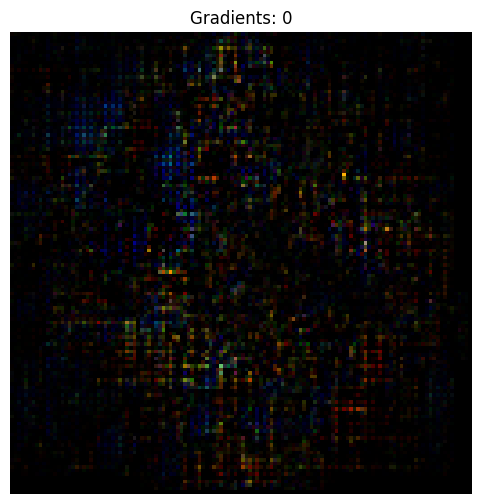

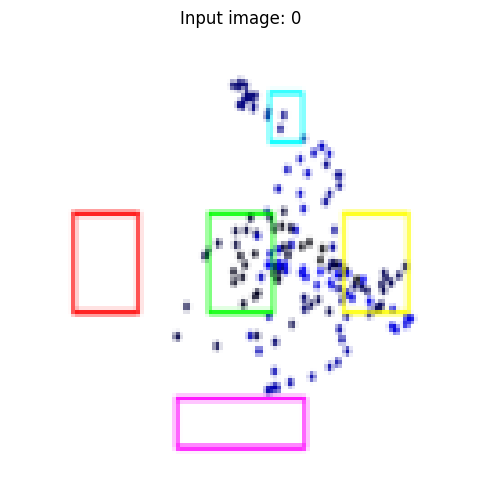

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for imgs, labs in outer_cv.get_test_loader():
    i = 0
    lab = labs[i]
    input_image = imgs[i].clone().detach().requires_grad_(True)
    # Set the model to evaluation mode
    trainer.model.eval()
    trainer.model.cpu()
    
    # Forward pass to get the output
    output = trainer.model.forward(input_image.unsqueeze(0))  # Adding batch dimension
    _, pred = torch.max(output, 1)
    # Calculate gradients of the output with respect to the input image
    output.squeeze()[pred].backward()
    # Get the gradients from the input image
    gradients = input_image.grad.squeeze().numpy()
    gradients[gradients<0] = 0
    gradients = gradients / np.max(gradients)

    # Plot the gradients
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(gradients, (1, 2, 0)) )
    plt.title(f'Gradients: {pred.item()}')
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(input_image.detach().cpu().numpy(), (1, 2, 0)) )
    plt.title(f'Input image: {lab}')
    plt.axis('off')
    plt.show()
    
